The contents of this course including lectures, labs, homework assignments, and exams have all been adapted from the [Data 8 course at University California Berkley](https://data.berkeley.edu/education/courses/data-8). Through their generosity and passion for undergraduate education, the Data 8 community at Berkley has opened their content and expertise for other universities to adapt in the name of undergraduate education.

In [1]:
#!pip install datascience
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

# Chapter 13: Estimation

In this chapter, we will develop a way to estimate an unknown parameter. Remember that a parameter is a numerical value associated with a population.

A statistic based on a random sample can be a reasonable estimate of an unknown parameter in the population. For example, you might want to use the median annual income of sampled households as an estimate of the median annual income of all households in the U.S.

But the value of any statistic depends on the sample, and the sample is based on random draws. So every time data scientists come up with an estimate based on a random sample, they are faced with a question:

**“How different could this estimate have been, if the sample had come out differently?”**

* Numerical data can be ranked.  Sorted in increasing or decreasing order
* Precentiles are used to rank how many numbers are above or below a given value
* If you score in 95th percentile on a test, you can conclude that 5% of the scores were higher than yours.
* What if everyone scored 75% on a test, how would you rank the precentiles?  Who scored in the 50% or 95% precentiles?
* We need a definition of precentiles that works consistently for all ranks and all lists.


* We will define the 80th percentile of a collection of values to be the smallest value in the collection that is at least as large as 80% of all of the values.

For example, let’s consider the sizes of the five largest continents – Africa, Antarctica, Asia, North America, and South America – rounded to the nearest million square miles.

In [2]:
sizes = make_array(12, 17, 6, 9, 7)

The 80th percentile is the smallest value that is at least as large as 80% of the elements of sizes, that is, four-fifths of the five elements. That’s 12:

In [3]:
np.sort(sizes)

array([ 6,  7,  9, 12, 17], dtype=int64)

The 80th percentile is a value on the list, namely 12. You can see that 80% of the values are less than or equal to it, and that it is the smallest value on the list for which this is true.

The percentile function takes two arguments: a rank between 0 and 100, and a array. It returns the corresponding percentile of the array.

In [4]:
percentile(70, sizes)

12

#### A General Definition of Precentiles

Let be a number between 0 and 100. The ***pth** percentile of a collection is the smallest value in the collection that is at least as large as p% of all the values.

By this definition, any percentile between 0 and 100 can be computed for any collection of values, and it is always an element of the collection.

In practical terms, suppose there are ***n*** elements in the collection. To find the ***pth*** percentile:

* Sort the collection in increasing order.
* Find p% of n: (p/100) X n.  Call that ***k***
* If ***k*** is an integer, take the ***kth*** element of the sorted collection.
* If ***k*** is not an integer, round it up to the next integer, and take that element of the sorted collection.


The table scores_and_sections contains one row for each student in a class of 359 students. The columns are the student’s discussion section and midterm score.

In [6]:
scores_and_sections = Table.read_table('scores_by_section.csv')
scores_and_sections

Section,Midterm
1,22
2,12
2,23
2,14
1,20
3,25
4,19
1,24
5,8
6,14


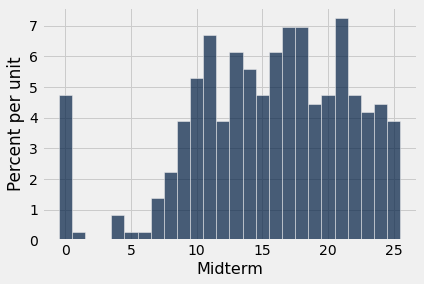

In [7]:
scores_and_sections.select('Midterm').hist(bins=np.arange(-0.5, 25.6, 1))

What was the 85th percentile of the scores?

In [8]:
scores = scores_and_sections.column(1)
percentile(85, scores)

22

According to the percentile function, the 85th percentile was 22. To check that this is consistent with our new definition, let’s apply the definition directly.

First, put the scores in increasing order:

In [9]:
sorted_scores = np.sort(scores_and_sections.column(1))

In [10]:
0.85 * 359

305.15

That’s not an integer. By our definition, the 85th percentile is the 306th element of sorted_scores, which, by Python’s indexing convention, is item 305 of the array.

In [11]:
sorted_scores.item(305)

22

#### Quartiles

The first quartile of a numercial collection is the 25th percentile. The terminology arises from the first quarter. The second quartile is the median, and the third quartile is the 75th percentile.

In [12]:
percentile(25, scores)

11

In [13]:
percentile(50, scores)

16

In [14]:
percentile(75, scores)

20

### The Bootstrap

* A data scientist uses data in a random sample to estimate an unknown parameter uses the sample to calculate the value of a statistic. 
* But a random sample is just one of numerous possible random samples, and thus the estimate is just one of numerous plausible estimates
* By how much could those estimates vary? To answer this, we need to draw another sample from the population, and compute a new estimate based on the new sample
* But we doen’t always have the resources to go back to the population and draw another sample
* Bootstrap method to the rescue!
* Bootstrap generates new random samples by a method called resampling: the new samples are drawn at random from the original sample.

#### Case Study: Employee Compensation in the Fort Collins

[Colorado Information Marketplace](https://data.colorado.gov/) is a website where Colorado makes some of their data publicly available. One of the data sets contains compensation data for employees of the city of Fort Collins. These include medical professionals at City-run hospitals, police officers, fire fighters, transportation workers, elected officials, and all other employees of the Fort Collins.

Compensation data for the calendar year 2020 are in the table fc2020.

In [38]:
fc2020 = Table.read_table('2020_Fort_Collins_City_Employee_Base_Pay.csv')
fc2020.show(3)

Job Title,Department,Service Area,Annual Salary
City Manager,City Manager's Office,Executive Services,278475
Broadband Executive Director,Broadband,Utility Services,248000
City Attorney,City Attorney's Office,Legal Services,206090


In [39]:
fc2020.where('Job Title', 'City Manager')

Job Title,Department,Service Area,Annual Salary
City Manager,City Manager's Office,Executive Services,278475


In [42]:
fc2020.sort('Annual Salary')

Job Title,Department,Service Area,Annual Salary
Answer Center Technician,Library District,Library District,16943.5
Bailiff,Municipal Court,Judicial Services,17846.4
Homebound Services Assistant,Library District,Library District,18209.9
Asst Circulation Supervisor,Library District,Library District,18516.9
Deputy Court Clerk I,Municipal Court,Judicial Services,18988.3
Asst Circulation Supervisor,Library District,Library District,19068.7
Asst Circulation Supervisor,Library District,Library District,19083.7
Asst Circulation Supervisor,Library District,Library District,19651.6
Answer Center Technician,Library District,Library District,20224.3
Asst Circulation Supervisor,Library District,Library District,20245.8


In [43]:
fc2020.num_rows

1893

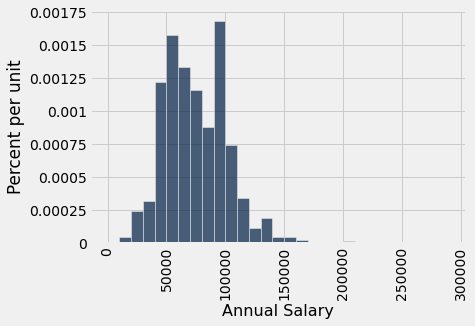

In [45]:
fc_bins = np.arange(0, 300000, 10000)
fc2020.select('Annual Salary').hist(bins=fc_bins)

In [46]:
fc2020.sort('Annual Salary', descending=True).show(2)

Job Title,Department,Service Area,Annual Salary
City Manager,City Manager's Office,Executive Services,278475
Broadband Executive Director,Broadband,Utility Services,248000


Suppose the parameter in which we are interested is the median of the total compensations.

Since we have the luxury of having all of the data from the population, we can simply calculate the parameter:

In [48]:
pop_median = percentile(50, fc2020.column('Annual Salary'))
pop_median

71847.03

The median total compensation of all the employees was 135,747 dollars.

From a practical perspective, there is no reason for us to draw a sample to estimate this parameter since we simply know its value. But in this section we are going to pretend we don’t know the value, and see how well we can estimate it based on a random sample.

In later sections, we will come down to earth and work in situations where the parameter is unknown. For now, we are all-knowing.

Let us draw a sample of 500 employees at random without replacement, and let the median total compensation of the sampled employees serve as our estimate of the parameter.

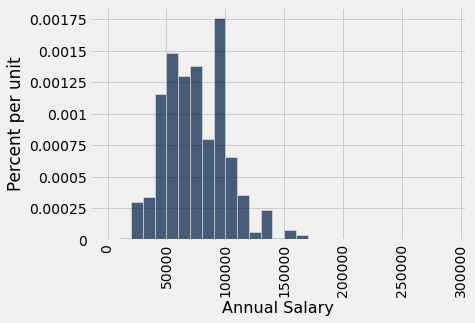

In [55]:
our_sample = fc2020.sample(500, with_replacement=False)
our_sample.select('Annual Salary').hist(bins=fc_bins)

In [56]:
est_median = percentile(50, our_sample.column('Annual Salary'))
est_median

73070.57

* The above sample size is large. By the law of averages, the distribution of the sample resembles that of the population. 
* We have one estimate of the parameter 
* The estimate would have had a different value if we sampled from a different population. 
* Thw measure of variability between samples will help us measure how accurately we can estimate the parameter.
* We could just draw another sample from the population and see how different the the parameter is. 
* But we are trying to mimic real life where we won’t have all the population data at hand.
* What we do have is a large random sample from the population which is likely to resemble the population from which it is drawn. 
* This observation allows us to lift ourselves up by our bootstraps: the sampling procedure can be replicated by sampling from the sample.

Here are the steps of the bootstrap method for generating another random sample that resembles the population:

* Treat the original sample as if it were the population.
* Draw from the sample, at random with replacement, the same number of times as the original sample size.


* Recall that the sample method draws rows from a table with replacement by default, and when not specifying a sample size, the sample size equals the number of rows of the table. 


In [57]:
resample_1 = our_sample.sample()

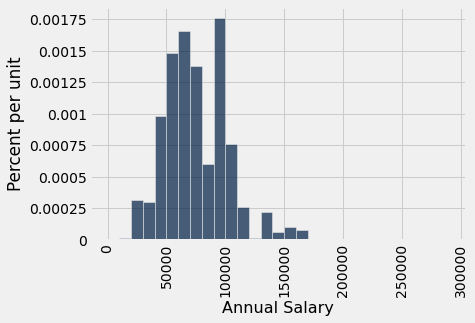

In [59]:
resample_1.select('Annual Salary').hist(bins=fc_bins)

In [61]:
resampled_median_1 = percentile(50, resample_1.column('Annual Salary'))
resampled_median_1

71760.0

This value is an estimate of the population median.

By resampling again and again, we can get many such estimates, and hence an empirical distribution of the estimates.

In [62]:
resample_2 = our_sample.sample()
resampled_median_2 = percentile(50, resample_2.column('Annual Salary'))
resampled_median_2

75505.41

Let us collect this code and define a function one_bootstrap_median that returns one bootstrapped median of total compensation, based on bootstrapping the original random sample that we called our_sample.

In [63]:
def one_bootstrap_median():
    resampled_table = our_sample.sample()
    bootstrapped_median = percentile(50, resampled_table.column('Annual Salary'))
    return bootstrapped_median

In [71]:
one_bootstrap_median()

72294.13

We can now repeat the bootstrap process multiple times by running a for loop and appending the data as usual.

In [74]:
num_repetitions = 5000
bstrap_medians = make_array()
for i in np.arange(num_repetitions):
    bstrap_medians = np.append(bstrap_medians, one_bootstrap_median())

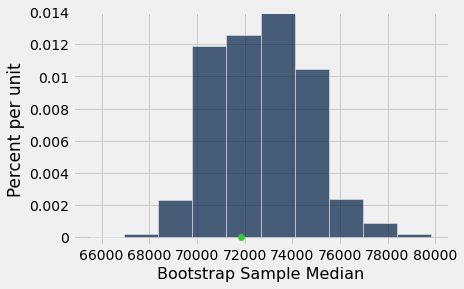

In [78]:
resampled_medians = Table().with_column('Bootstrap Sample Median', bstrap_medians)
resampled_medians.hist()

# Plotting parameters; you can ignore this code
parameter_green = '#32CD32'
plots.ylim(-0.000005, 0.00014)
plots.scatter(pop_median, 0, color=parameter_green, s=40, zorder=2);

Here is an empirical histogram of the 5000 bootstrapped medians. The green dot is the population parameter: it is the median of the entire population, which is what we are trying to estimate. In this example we happen to know its value, but we did not use it in the bootstrap process.

* It is important to remember that the green dot is fixed: it is 71847.03 dollars, the population median. 
* The empirical histogram is the result of random draws, and will be situated randomly relative to the green dot.
* Our estimates are all the randomly generated sampled medians whose histogram you see above. We want the set of these estimates to contain the parameter. If it doesn’t, then the estimates are off.

Do the Estimates Capture the Parameter?
* How often does the empirical histogram of the resampled medians sit firmly over the green dot?
* Lets assume that "firmly" means “the middle 95% of the resampled medians contains the green dot”


Here are the two ends of the “middle 95%” interval of resampled medians:

In [79]:
left = percentile(2.5, bstrap_medians)
left

69626.96

In [80]:
right = percentile(97.5, bstrap_medians)
right

76457.25

The population median of 71847.03 dollars is between these two numbers. The interval and the population median are shown on the histogram below.

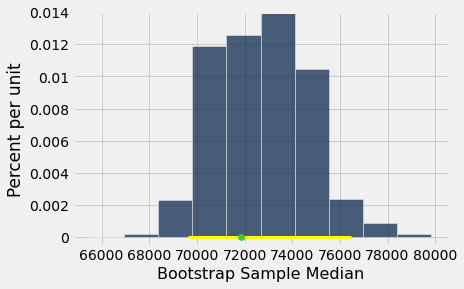

In [82]:
resampled_medians.hist()

# Plotting parameters; you can ignore this code
plots.ylim(-0.000005, 0.00014)
plots.plot([left, right], [0, 0], color='yellow', lw=3, zorder=1)
plots.scatter(pop_median, 0, color=parameter_green, s=40, zorder=2);

The “middle 95%” interval of estimates captured the parameter in our example. But was that a fluke?

To see how frequently the interval contains the parameter, we have to run the entire process over and over again. Specifically, we will replicate the following process 100 times:

In [86]:
def bootstrap_median(original_sample, num_repetitions):
    medians = make_array()
    for i in np.arange(num_repetitions):
        new_bstrap_sample = original_sample.sample()
        new_bstrap_median = percentile(50, new_bstrap_sample.column('Annual Salary'))
        medians = np.append(medians, new_bstrap_median)
    return medians

In [88]:
left_ends = make_array()
right_ends = make_array()

for i in np.arange(100):
    original_sample = fc2020.sample(500, with_replacement=False)
    medians = bootstrap_median(original_sample, 5000)
    left_ends = np.append(left_ends, percentile(2.5, medians))
    right_ends = np.append(right_ends, percentile(97.5, medians))

intervals = Table().with_columns(
    'Left', left_ends,
    'Right', right_ends
)    

In [89]:
intervals

Left,Right
69010,78157.2
68657.2,76635
69006.7,75787.9
69752,76932
68725,78047.4
68951,77603
66008.9,75505.4
66164.7,72800
66950,73411
65641.9,75132


In [90]:
pop_median

71847.03

How many of the 100 intervals contain the population median? 

In [91]:
intervals.where(
    'Left', are.below(pop_median)).where(
    'Right', are.above(pop_median)).num_rows

100

* Our estimation produced a good interval about 95% of the time.
* We say that we are 95% confident that the process results in a good interval
* Our interval of estimates is called a 95% confidence interval for the parameter

* The situation in the previous example was a bit unusual because we knew the value of the parameter
* Usually data scientists don’t know the value of the parameter

The table births contains the following variables for mother-baby pairs: the baby’s birth weight in ounces, the number of gestational days (the number of days the mother was pregnant), the mother’s age in completed years, the mother’s height in inches, pregnancy weight in pounds, and whether or not the mother smoked during pregnancy.

In [92]:
births = Table.read_table('baby.csv')

In [93]:
births.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


* Birth weight is an important factor in the health of a newborn infant.
* We will consider the relationship between birth weight and the number of gestational days.

In [94]:
ratios = births.select('Birth Weight', 'Gestational Days').with_columns(
    'Ratio BW:GD', births.column('Birth Weight')/births.column('Gestational Days')
)
ratios

Birth Weight,Gestational Days,Ratio BW:GD
120,284,0.422535
113,282,0.400709
128,279,0.458781
108,282,0.382979
136,286,0.475524
138,244,0.565574
132,245,0.538776
120,289,0.415225
143,299,0.478261
140,351,0.39886


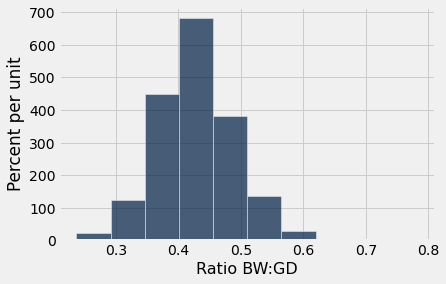

In [95]:
ratios.select('Ratio BW:GD').hist()

At first glance the histogram looks quite symmetric, with the density at its maximum over the interval 0.4 ounces per day to 0.45 ounces per day. But a closer look reveals that some of the ratios were quite large by comparison.

In [96]:
ratios.sort('Ratio BW:GD', descending=True).take(0)

Birth Weight,Gestational Days,Ratio BW:GD
116,148,0.783784


In [97]:
percentile(50, ratios.column(2))

0.42907801418439717

But what was the median in the population? 

We will start by defining a function one_bootstrap_median. It will bootstrap the sample and return one the median ratio in the bootstrapped sample.

In [98]:
def one_bootstrap_median():
    resample = ratios.sample()
    return percentile(50, resample.column('Ratio BW:GD'))

In [157]:
one_bootstrap_median()

0.43018867924528303

Now we can use a for loop to generate 5000 bootstrapped medians.

In [148]:
# Generate medians from 5000 bootstrap samples
num_repetitions = 5000
bstrap_medians = make_array()
for i in np.arange(num_repetitions):
    bstrap_medians = np.append(bstrap_medians, one_bootstrap_median())

In [158]:
left = percentile(2.5, bstrap_medians)
right = percentile(97.5, bstrap_medians)

make_array(left, right)

array([0.42545455, 0.43262411])

The 95% confidence interval goes from about 0.425 ounces per day to about 0.433 ounces per day.

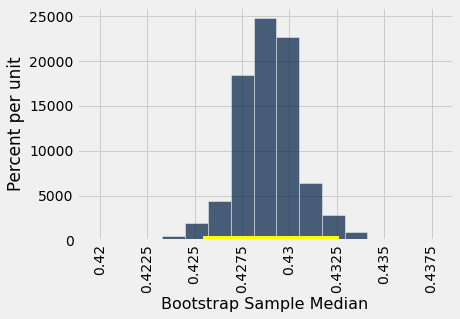

In [159]:
resampled_medians = Table().with_columns(
    'Bootstrap Sample Median', bstrap_medians
)
resampled_medians.hist(bins=15)
plots.plot([left, right], [0, 0], color='yellow', lw=8);

We just have an interval of estimates. It is a 95% confidence interval of estimates, because the process that generates it produces a good interval about 95% of the time. That certainly beats guessing the ratio at random! However, there is no green dot showing where the parameter is because we don’t know where that dot should be, or whether it is even in the interval.

The bootstrap is an elegant and powerful method. Before using it, it is important to keep some points in mind.

* Start with a large random sample. 
* To approximate the probability distribution of a statistic, it is a good idea to replicate the resampling procedure as many times as possible.
* The bootstrap percentile method works well for estimating the population median or mean based on a large random sample. However, it has limitations, as do all methods of estimation. For example, it is not expected to do well in the following situations.
    * The goal is to estimate the minimum or maximum value in the population, or a very low or very high percentile, or parameters that are greatly influenced by rare elements of the population.
    * The probability distribution of the statistic is not roughly bell shaped.
    * The original sample is very small, say less than 10 or 15.
